In [6]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as K
from collections import deque
import random

In [7]:
env = gym.make('CartPole-v1')

In [8]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


In [9]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(state_size)
print(action_size)

4
2


From above we can see that there are two actions that can be taken, thus the model must have two outputs.

We can also see that each state is defined by 4 features, thus our input size is 4.

In [10]:
# Create the model
DQN_model = K.models.Sequential()
DQN_model.add(K.layers.Dense(32, input_dim=state_size, activation='relu'))
DQN_model.add(K.layers.Dense(32, activation='relu'))
DQN_model.add(K.layers.Dense(action_size, activation='linear'))
DQN_model.compile(loss='mse', optimizer=K.optimizers.Adam(lr=0.001))

In [11]:
# DQN Agent Class
class DQN_Agent():
    def __init__(self, state_size, action_size, model):
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.995
        self.state_size = state_size
        self.action_size = action_size
        self.model = model
    
    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        
        sample_batch = random.sample(self.memory, sample_batch_size)
        
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [12]:
sample_batch_size = 32
episodes = 500
agent = DQN_Agent(state_size, action_size, DQN_model)

episode_list = []
score_list = []

# Train the agent
for index_episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    index = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        index += 1
    
    # start rendering the last few episodes
    if index_episode >= (episodes-20):
        env.render()
    
    print("Episode {} Score: {}".format(index_episode, index + 1))
    episode_list.append(index_episode)
    score_list.append(index+1)
    
    agent.replay(sample_batch_size)

Episode 0 Score: 28
Episode 1 Score: 28
Episode 2 Score: 43
Episode 3 Score: 17
Episode 4 Score: 12
Episode 5 Score: 26
Episode 6 Score: 19
Episode 7 Score: 56
Episode 8 Score: 13
Episode 9 Score: 11
Episode 10 Score: 11
Episode 11 Score: 24
Episode 12 Score: 35
Episode 13 Score: 15
Episode 14 Score: 11
Episode 15 Score: 26
Episode 16 Score: 39
Episode 17 Score: 19
Episode 18 Score: 33
Episode 19 Score: 16


Text(0.5, 0, 'Episode')

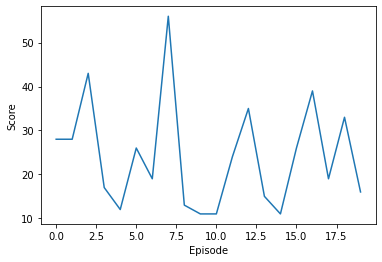

In [13]:
# Graph
plt.plot(episode_list, score_list)
plt.ylabel('Score')
plt.xlabel('Episode')